**Preparation**
1. Download [CelebAMask-HQ.zip](https://github.com/switchablenorms/CelebAMask-HQ#celebamask-hq-dataset-downloads)
2. Extract CelebAMask-HQ.zip

**Dataset Directory Structure**
```
Dataset
├─ CelebAMask-HQ
|  ├─ CelebA-HQ-img
|  ├─ CelebAMask-HQ-mask-anno
|  ├─ CelebA-HQ-to-CelebA-mapping.txt
|  ├─ CelebAMask-HQ-pose-anno.txt
|  ├─ CelebAMask-HQ-attribute-anno.txt
|  └─ README.txt
|
├─ train
|  ├─ photo
|  └─ sketch
|
├─ test
|  ├─ photo
|  └─ sketch
|
└─ dataset.ipynb
```

#### Initialize

In [1]:
import os, shutil, random
import cv2
from PIL import Image, ImageFilter, ImageOps, ImageEnhance 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
folder_CelebAMaskHQ_root = 'CelebAMask-HQ'
folder_CelebAMaskHQ_image = 'CelebA-HQ-img'
file_CelebAMaskHQ_pose = 'CelebAMask-HQ-pose-anno.txt'
file_CelebAMaskHQ_attribute = 'CelebAMask-HQ-attribute-anno.txt'

folder_train = 'train'
folder_test = 'test'
folder_photo = 'photo'
folder_sketch = 'sketch'

In [3]:
image_file_names = os.listdir(os.path.join(folder_CelebAMaskHQ_root, folder_CelebAMaskHQ_image))
print(len(image_file_names), image_file_names[:5])

30000 ['14968.jpg', '17407.jpg', '13853.jpg', '21559.jpg', '29674.jpg']


#### Check Faces Direction

In [4]:
poses = pd.DataFrame()
with open( os.path.join(folder_CelebAMaskHQ_root, file_CelebAMaskHQ_pose) ) as f:
    f.readline()
    columns = f.readline().split()
    data = f.readlines()
    data = np.array([datum.split() for datum in data])
    for i, column in enumerate(columns):
        poses[column] = data[:,i+1]
    poses = poses.astype(float)
    poses = poses.set_index(data[:,0])
    
poses

Yaw      Pitch       Raw
0.jpg     -16.761650  -3.540695 -0.468292
1.jpg       8.853630 -16.055931 -1.150886
2.jpg      35.265182  -6.890411 -1.581253
3.jpg     -16.793152   1.010948  0.133667
4.jpg       5.474228 -12.340668 -0.894409
...              ...        ...       ...
29995.jpg   0.108932  -0.664413  0.135849
29996.jpg   4.065002  -1.689423 -1.262672
29997.jpg   5.378021 -12.933311  1.843475
29998.jpg  16.967903  -6.059593 -3.954010
29999.jpg   5.022697 -10.445068  1.022980

[30000 rows x 3 columns]

In [5]:
lower_poses_threshold = -15
upper_poses_threshold = 15

In [6]:
new_image_file_names = []
for image_file_name in image_file_names:
    eligible = True
    for value in poses.loc[image_file_name]:
        if value < lower_poses_threshold or value > upper_poses_threshold:
            eligible = False
    if eligible: new_image_file_names.append(image_file_name)
    
image_file_names = new_image_file_names
print(len(image_file_names), image_file_names[:5])

18387 ['17407.jpg', '13853.jpg', '21559.jpg', '28841.jpg', '27322.jpg']


#### Check Faces Attributes

In [7]:
attributes = pd.DataFrame()
with open( os.path.join(folder_CelebAMaskHQ_root, file_CelebAMaskHQ_attribute) ) as f:
    f.readline()
    columns = f.readline().split()
    data = f.readlines()
    data = np.array([datum.split() for datum in data])
    for i, column in enumerate(columns):
        attributes[column] = data[:,i+1]
    attributes = attributes.astype(int)
    attributes = attributes.set_index(data[:,0])
    
attributes

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0.jpg                    -1                1           1                1   
1.jpg                    -1                1           1               -1   
2.jpg                    -1               -1           1                1   
3.jpg                    -1               -1           1               -1   
4.jpg                    -1               -1          -1               -1   
...                     ...              ...         ...              ...   
29995.jpg                -1               -1          -1               -1   
29996.jpg                 1               -1          -1                1   
29997.jpg                -1               -1          -1               -1   
29998.jpg                -1                1           1               -1   
29999.jpg                -1               -1           1               -1   

           Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
0.jpg        -1     -1         1        -1          -1          -1  ...   
1.jpg        -1     -1        -1        -1          -1           1  ...   
2.jpg        -1     -1         1        -1          -1          -1  ...   
3.jpg        -1     -1        -1         1           1          -1  ...   
4.jpg        -1     -1         1        -1          -1          -1  ...   
...         ...    ...       ...       ...         ...         ...  ...   
29995.jpg    -1     -1        -1         1          -1          -1  ...   
29996.jpg    -1     -1        -1         1          -1          -1  ...   
29997.jpg    -1      1        -1        -1           1          -1  ...   
29998.jpg    -1     -1        -1        -1          -1          -1  ...   
29999.jpg    -1      1        -1        -1          -1          -1  ...   

           Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0.jpg             -1        1             -1          1                -1   
1.jpg             -1        1             -1          1                -1   
2.jpg             -1        1             -1          1                 1   
3.jpg             -1        1             -1          1                -1   
4.jpg             -1       -1              1         -1                 1   
...              ...      ...            ...        ...               ...   
29995.jpg         -1        1             -1         -1                -1   
29996.jpg          1        1             -1         -1                -1   
29997.jpg         -1       -1              1         -1                -1   
29998.jpg         -1       -1             -1          1                -1   
29999.jpg         -1        1             -1          1                 1   

           Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
0.jpg               -1                 1                -1               -1   
1.jpg               -1                 1                -1               -1   
2.jpg               -1                 1                -1               -1   
3.jpg               -1                 1                -1               -1   
4.jpg               -1                -1                -1               -1   
...                ...               ...               ...              ...   
29995.jpg           -1                -1                 1               -1   
29996.jpg           -1                -1                -1               -1   
29997.jpg           -1                -1                -1               -1   
29998.jpg           -1                 1                -1               -1   
29999.jpg           -1                 1                -1               -1   

           Young  
0.jpg          1  
1.jpg          1  
2.jpg          1  
3.jpg          1  
4.jpg          1  
...          ...  
29995.jpg     -1  
29996.jpg      1  
29997.jpg      1  
29998.jpg      1  
29999.jpg     -1  

[30000 rows x 40 columns]

In [8]:
not_allowed_attributes = ['Eyeglasses', 'Wearing_Hat']

In [9]:
new_image_file_names = []
for image_file_name in image_file_names:
    eligible = True
    for not_allowed_attribute in not_allowed_attributes:
        if attributes.loc[image_file_name][not_allowed_attribute] == 1:
            eligible = False
    if eligible: new_image_file_names.append(image_file_name)
    
image_file_names = new_image_file_names
print(len(image_file_names), image_file_names[:5])

16909 ['17407.jpg', '13853.jpg', '21559.jpg', '28841.jpg', '27322.jpg']


#### Convert Train and Test Images

In [10]:
n_train_sample = 15000
assert(n_train_sample <= len(image_file_names))

random.shuffle(image_file_names)
train_image_file_names = image_file_names[:n_train_sample]
test_image_file_names = image_file_names[n_train_sample:]

# train_image_file_names = image_file_names[:10]
# test_image_file_names = image_file_names[10:15]

print(len(train_image_file_names), train_image_file_names[:5])
print(len(test_image_file_names), test_image_file_names[:5])

15000 ['18629.jpg', '6506.jpg', '14222.jpg', '3044.jpg', '933.jpg']
1909 ['18050.jpg', '227.jpg', '370.jpg', '24727.jpg', '20855.jpg']


#### Copy Images to Photo Folder

In [11]:
shutil.rmtree( os.path.join(folder_train, folder_photo) )
shutil.rmtree( os.path.join(folder_test, folder_photo) )

In [12]:
os.makedirs( os.path.join(folder_train, folder_photo) )
os.makedirs( os.path.join(folder_test, folder_photo) )

In [13]:
for image_file_name in tqdm(train_image_file_names, desc='Train'):
    image = cv2.imread( os.path.join(folder_CelebAMaskHQ_root, folder_CelebAMaskHQ_image, image_file_name) )
    image = cv2.resize(image, (512, 512))
    cv2.imwrite( os.path.join(folder_train, folder_photo, image_file_name), image)

for image_file_name in tqdm(test_image_file_names, desc='Test'):
    image = cv2.imread( os.path.join(folder_CelebAMaskHQ_root, folder_CelebAMaskHQ_image, image_file_name) )
    image = cv2.resize(image, (512, 512))
    cv2.imwrite( os.path.join(folder_test, folder_photo, image_file_name), image)

Test: 100%|██████████████████████████████████████████████████████| 1909/1909 [01:04<00:00, 29.45it/s]


#### Convert  Images to Sketch and Copy Images to Sketch Folder

Sketch simplification:
* [original](https://github.com/bobbens/sketch_simplification)

* [torch 1.x](https://github.com/ramilmsh/sketch_simplification)

In [14]:
shutil.rmtree( os.path.join(folder_train, folder_sketch) )
shutil.rmtree( os.path.join(folder_test, folder_sketch) )

In [15]:
os.makedirs( os.path.join(folder_train, folder_sketch) )
os.makedirs( os.path.join(folder_test, folder_sketch) )

In [16]:
class convert2sketch():
    
    def __init__(self, folder_sketch_simplification):
        self.folder_sketch_simplification = folder_sketch_simplification
        
    def simplify(self, path_img, path_out):
        cwd = os.getcwd()
        os.chdir(self.folder_sketch_simplification)
        os.system(f"python3 simplify.py --img {cwd}/{path_img} --out {cwd}/{path_out}")
        os.chdir(cwd)
        
    def edge(self, image):
        image = image.filter(ImageFilter.FIND_EDGES)
        image = image.filter(ImageFilter.BLUR)
        image = image.filter(ImageFilter.SHARPEN)
        image = ImageOps.invert(image)
        image = ImageEnhance.Contrast(image).enhance(1.5)
        return image
        
    def convert_single(self, source, target):
        image = Image.open(source)
        image = self.edge(image)
        image = image.save(target)
#         self.simplify(target, target)
    
    def convert_folder(self, source, target):
        for image_file_name in tqdm(os.listdir(source)):
            self.convert_single( os.path.join(source, image_file_name), os.path.join(target, image_file_name) )
            

In [17]:
c2s = convert2sketch('sketch_simplification')
c2s.convert_folder( os.path.join(folder_train, folder_photo), os.path.join(folder_train, folder_sketch) )
c2s.convert_folder( os.path.join(folder_test, folder_photo), os.path.join(folder_test, folder_sketch) )

100%|████████████████████████████████████████████████████████████| 1909/1909 [00:55<00:00, 34.34it/s]


#### Preview Result

In [18]:
def display(folder, num=5, shuffle=True):
    image_file_names = os.listdir(os.path.join(folder, folder_photo))
    if shuffle: random.shuffle(image_file_names)
    
    assert num <= len(image_file_names)
    
    f, axarr = plt.subplots(2, num, figsize=(10 * num, 10 * 2), squeeze=False)
    f.tight_layout()
    
    for i, image_file_name in enumerate(image_file_names[:num]):
        image = Image.open(os.path.join(folder, folder_photo, image_file_name))
        axarr[0,i].imshow(image)
        axarr[0,i].set_xticks([])
        axarr[0,i].set_yticks([])
    
    for i, image_file_name in enumerate(image_file_names[:num]):
        image = Image.open(os.path.join(folder, folder_sketch, image_file_name))
        axarr[1,i].imshow(image)
        axarr[1,i].set_xticks([])
        axarr[1,i].set_yticks([])

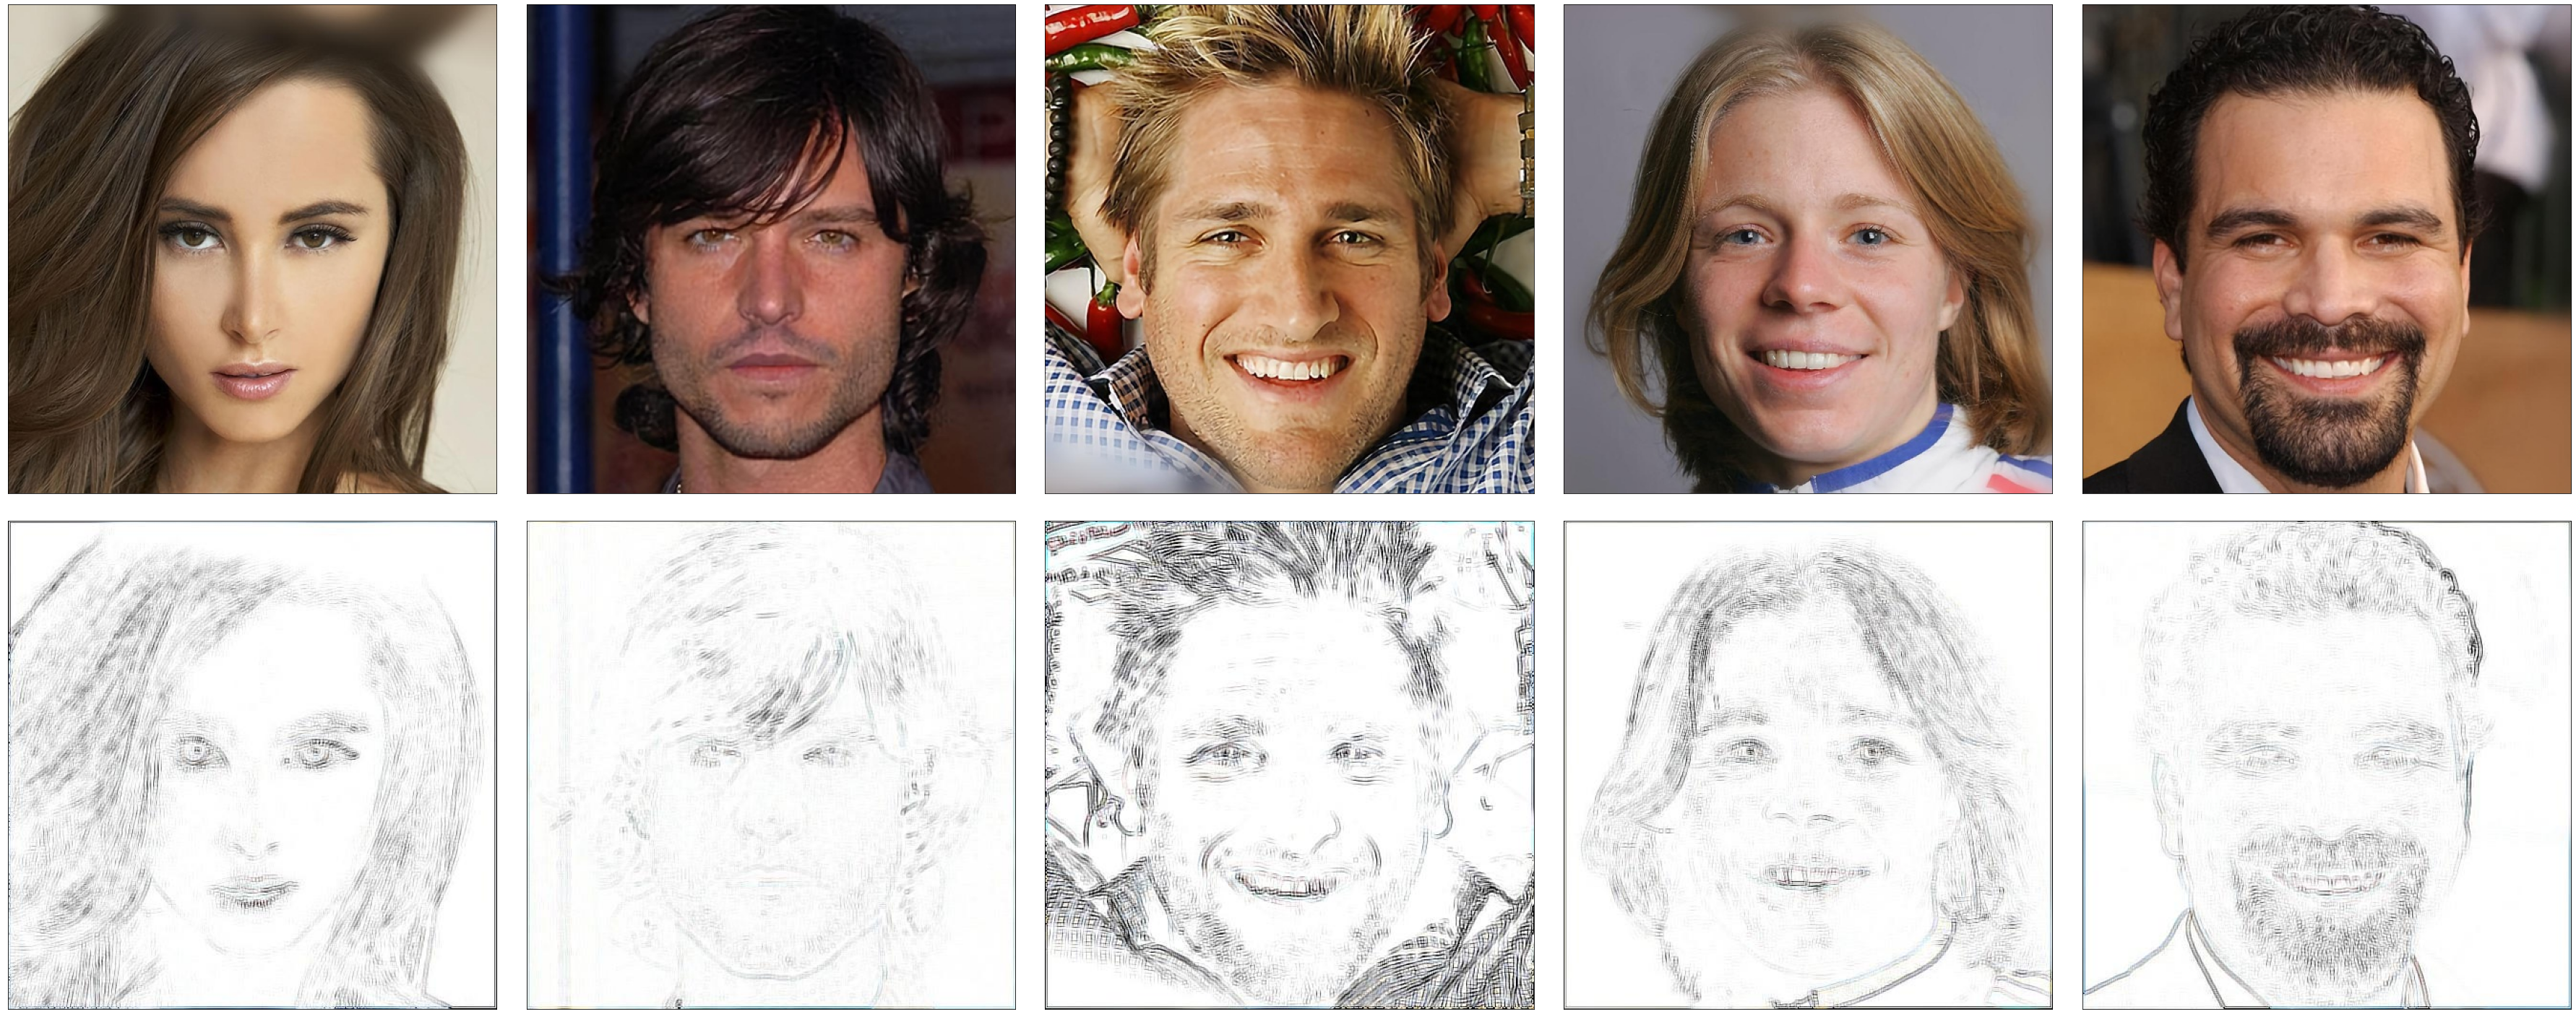

In [19]:
display(folder_train, num=5)